# Extended Phase Graphs Tutorial

Extended phase graphs (EPGs) are a powerful tool for MRI signal analysis.  Put simply, the EPG formalism (1) is a Fourier representation of transverse and longitudinal magnetization within a voxel and (2) EPG coefficients can very efficiently be propagated through common sequence operations (nutation, relaxation, gradients and diffusion) to easily and accurately simulate many common MRI pulse sequences.

## Setup
Our functions are in mrsigpy.py, so we will import that.

In [1]:
import numpy as np
import mrsigpy as mrs
import matplotlib.pyplot as plt

%matplotlib inline

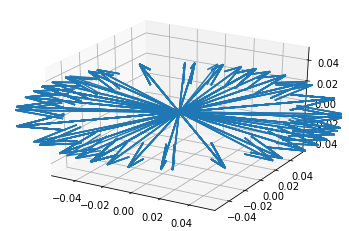

In [2]:
mrs._3dspins()

## EPG Definition
The EPG basis consists of coefficients $F_n$ and $Z_n$, to represent transverse and longitudinal magnetization, respectively.  There are different conventions for these, but we use $F_n$ where $n$ is any integer and $Z_n$ where $n \ge 0$.  

The subscript n refers to the number of cycles of dephasing, assumed to be an integer.  The transverse magnetization is expressed as $m_{xy} = m_x + i*m_y$, and longitudinal magnetization is $m_z$.  Then we write a real-valued vector $M = [m_{xy} m^\ast_{xy} m_z]^T$.

Now if we consider a variable $z$ which is the position within the voxel, we can express $m$ using a Fourier basis:

$$m_{xy}(z) = \sum_{n=-\infty}^{\infty} F_n e^{2\pi i z}$$

This shows that $m_{xy}(z)$ is written using basis functions that are just twists ($e^{2\pi i z}$) and the basis coefficients are $F_n$.  This is just an inverse Fourier transform!

$m_z$ is a bit trickier to see from the inverse Fourier transform, since it is real-valued, but looks like this:

$$m_z(z) = \Re \{ \sum_{n=0}^{\infty} Z_n e^{2\pi i z} \}$$


## EPG State Matrix
For simulation it is convenient to write the ($F$) and ($Z$) coefficients into a matrix with  $F_n$, $n\ge0$ in row 1, $F_n$, $n\ge0$ in row 2, and $Z_n ($n\ge0$) in row 3 as shown.  We call this matrix `FZ` (sometimes `FpFmZ`) in the code functions.

$$\left[ \begin{matrix} F_0 & F_1 & F_2 & \cdots & F_n \\ 
                F_{-0} & F_{-1} & F_{-2} & \cdots & F_{-n} \\
                Z_0 & Z_1 & Z_2 & \cdots & Z_n \\
                \end{matrix} \right]$$

## Graphical display of states
`epg_show()` is a single graphical display the EPG decomposition, with coefficients above the basis graphics.  Because the leftmost element of the second row $F_{-0}$ is redundant ($F_{-0}=F^\ast_0$), instead of showing this state, the complete magnetization distribution is shown here.  It is a bit less cumbersome to show the full magnetization with all vectors originating from (0,0,0).  Transverse ($F$) states can be viewed as twists or from above as circular distributions.   Longitudinal ($Z$) states are most easily viewed with the voxel dimension along x.  _Make sure you understand this concept!_

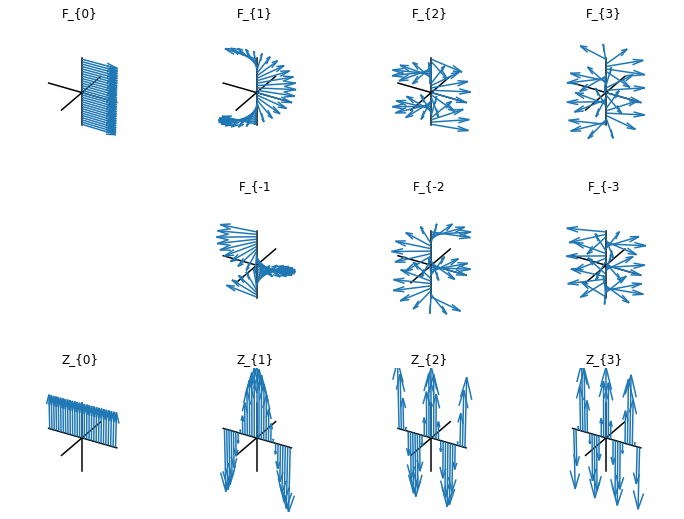

In [7]:
# -- We just want to show ALL basis vectors here, so set all to 1.
FZ = np.ones((3,4))
#FZ = np.array([[0.5,0.5],[0.5,0.3],[0.2,0.2]])

# -- Show all the states.  
#   Note that we skip showing the full magnetization 
#   because it is much greater than 1 in this "hyperpolarized(!)" example.

mrs.epg_show(FZ,29,skipfull=True)

plt.rcParams["figure.figsize"] = (20,10)


## RF Rotations
`epg_rf()` will rotate magnetization by an angle `alpha` about a transverse axis an angle phi away from the $m_x$ axis.  The default for `epg_rf()` here is a simple $90_y$ degree excitation, which moves magnetization from $m_z$ to $m_x$.  The _key_ property of RF rotations in EPG is that they mix $F_n$, $F_{-n}$ and $Z_n$ for one $n$ but _do not_ mix magnetization between any states with different $n$.

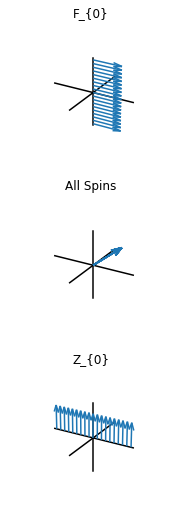

In [4]:
# RF Example 1
# alpha_phi Excitation
FZ = np.array([[0],[0],[1]])    # Equilibrium magnetization, along m_z
FZ = mrs.epg_rf(FZ,alpha=45,phi=90)             # 90 rotation along m_y
mrs.epg_show(FZ)
# -- Exercise --
# Try changing the flip angle (alpha) and phase (phi) here.
# Note the real/imaginary parts of F_0 when you do this!

Text(0.5, 0.98, 'Magnetization after RF')

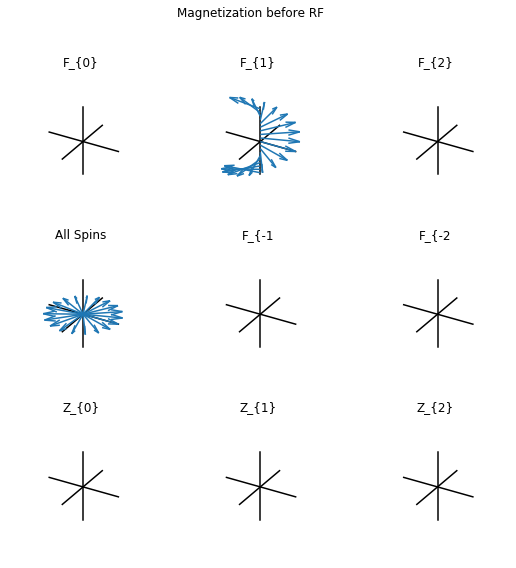

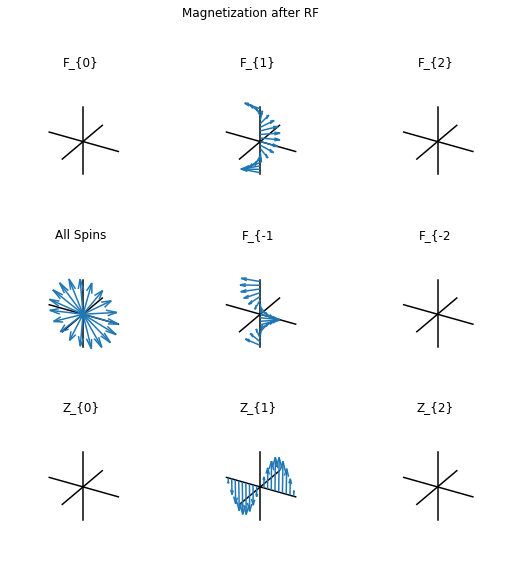

In [12]:
# RF Example 2
# Rotation with nonzero F_1 state
FZ = np.array([[0,1,0],[0,0,0],[0,0,0]])
mrs.epg_show(FZ)
plt.suptitle('Magnetization before RF')
FZ = mrs.epg_rf(FZ,90,0)
mrs.epg_show(FZ)
plt.suptitle('Magnetization after RF')
# -- Exercise --
# a) Try changing the flip angle and phase to see how the "mixing" changes.
# b) Try starting with F_{-1} or Z_1 = 1 and the other states 0.

## Gradients
Gradients simply move the $F_n$ coefficients around.  

Text(0.5, 0.98, 'After Negative Gradients, 1 cycle')

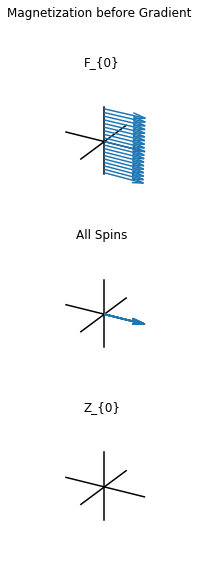

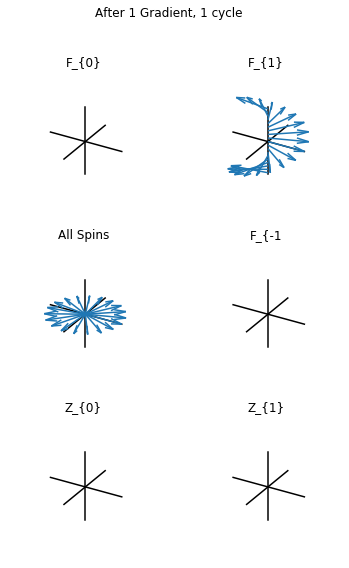

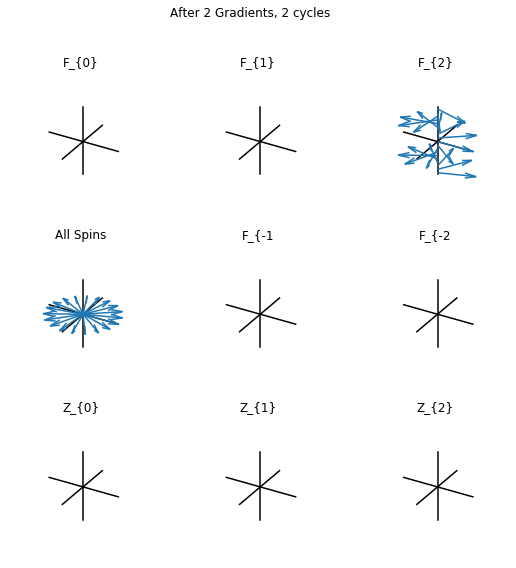

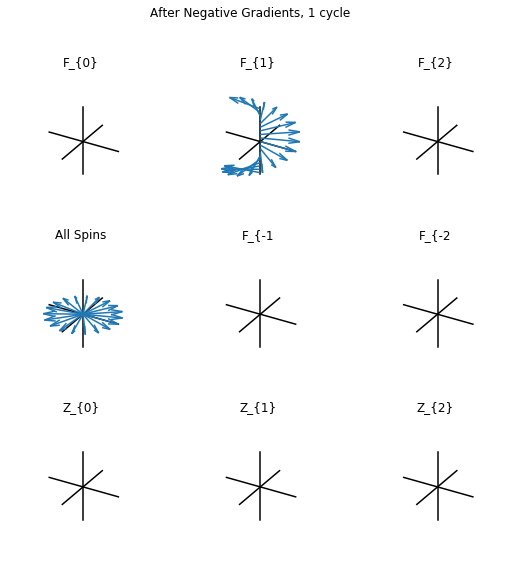

In [14]:
# Just start with F_{0}
FZ = np.array([[1],[0],[0]])
mrs.epg_show(FZ)
plt.suptitle('Magnetization before Gradient')      # In-phase, along Mx
FZ = mrs.epg_grad(FZ) 
mrs.epg_show(FZ)
plt.suptitle('After 1 Gradient, 1 cycle')      
FZ = mrs.epg_grad(FZ)
mrs.epg_show(FZ)
plt.suptitle('After 2 Gradients, 2 cycles')     
FZ = mrs.epg_grad(FZ,noadd=True,positive = False)   # Negative gradient!
mrs.epg_show(FZ)
plt.suptitle('After Negative Gradient, 1 cycle')      
# -- Exercise --
# a) Try adding more non-zero states at the start
# b) Combine with an RF pulse between gradients


## EPG to Spins:  Fourier Transform
We can easily convert between the EPG representation and to $M = [m_x m_y m_z]^T$ or "spins" using a Fourier transform (with a bit of rearranging).  Note that the number of spins in a voxel should be at least as high as the number of non-zero states ($n$).  The $M$ returned is an array of spins at different $z$ locations.  Again remember $z$ is just "across" a voxel, so quite arbitary.

In [6]:
FZ = np.array([[1],[1],[0]])
M = mrs.epg_FZ2spins(FZ,9)
print("M for all magnetization along m_x:\n",M)
M = mrs.epg_FZ2spins(epg_grad(FZ),9)
print("M for one dephased cycle:\n",M)




M for all magnetization along m_x:
 [[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


NameError: name 'epg_grad' is not defined